In [233]:
import json
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from matplotlib.patches import Arc
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class

import pandas as pd
from pandas.io.json import json_normalize

from utils.match import *
from utils.player import *

# Passing Networks

In [264]:
lineups_path = "data/statsbomb360/lineups/3788766.json"
events_path = "data/statsbomb360/events/3788766.json"

match_id = 3788766
team_name = "Wales"
home_team = False

In [235]:
def json_to_normalized_dataframe(path):
    '''
    Converts a json file to a pandas dataframe
    '''
    obj = read_json(path)
    df = pd.json_normalize(obj)
    return df
    
def read_json(path):
    '''
    Read JSON file from path
    '''
    return json.loads(read(path))


def read(path):
    '''
    Read content of a file
    '''
    with open(path, 'r', encoding="UTF-8") as f:
        return f.read()

In [236]:
lineups = read_json(lineups_path)
names_dict = {player["player_name"]: player["player_nickname"] for team in lineups for player in team["lineup"]}

events = read_json(events_path)
df_events = json_normalize(events, sep="_").assign(match_id=match_id)

/var/folders/74/wgylnqh57czdw7v6n0vzbw540000gn/T/ipykernel_39959/1231522130.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_events = json_normalize(events, sep="_").assign(match_id=match_id)


In [237]:
first_red_card_minute = df_events[df_events.foul_committed_card_name.isin(["Second Yellow", "Red Card"])].minute.min()
first_substitution_minute = df_events[df_events.type_name == "Substitution"].minute.min()
max_minute = df_events.minute.max()

num_minutes = min(first_substitution_minute, first_red_card_minute, max_minute)
num_minutes

45

In [238]:
plot_name = "{0}_{1}_passing_network".format(match_id, team_name)
opponent_team = [x for x in df_events.team_name.unique() if x != team_name][0]
plot_title ="{0}'s passing network against {1}".format(team_name, opponent_team)
plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"

In [239]:
def _statsbomb_to_point(location, max_width=120, max_height=80):
    '''
    Convert a point's coordinates from a StatsBomb's range to 0-1 range.
    '''
    return location[0] / max_width, 1 - (location[1] / max_height)

In [240]:
df_passes = df_events[(df_events.type_name == "Pass") &
                      (df_events.pass_outcome_name.isna()) &
                      (df_events.team_name == team_name) &
                      (df_events.minute < num_minutes)].copy()

# If available, use player's nickname instead of full name to optimize space in plot
df_passes["pass_recipient_name"] = df_passes.pass_recipient_name.apply(lambda x: names_dict[x] if names_dict[x] else x)
df_passes["player_name"] = df_passes.player_name.apply(lambda x: names_dict[x] if names_dict[x] else x)

In [241]:
df_passes["origin_pos_x"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[0])
df_passes["origin_pos_y"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[1])
player_position = df_passes.groupby("player_name").agg({"origin_pos_x": "median", "origin_pos_y": "median"})

In [242]:
player_pass_count = df_passes.groupby("player_name").size().to_frame("num_passes")
player_pass_value = df_passes.groupby("player_name").size().to_frame("pass_value")

In [243]:
df_passes["pair_key"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
pair_pass_count = df_passes.groupby("pair_key").size().to_frame("num_passes")
pair_pass_value = df_passes.groupby("pair_key").size().to_frame("pass_value")

In [244]:
config = read_json("plot_config.json")
height = float(config["height"])
width = float(config["width"])


def _point_to_meters(p):
    '''
    Convert a point's coordinates from a 0-1 range to meters.
    '''
    return np.array([p[0]*width, p[1]*height])


def _change_range(value, old_range, new_range):
    '''
    Convert a value from one range to another one, maintaining ratio.
    '''
    return ((value-old_range[0]) / (old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]


def draw_pitch(min_x=0, max_x=1):
    """
    Plot an empty horizontal football pitch, returning Matplotlib's ax object so we can keep adding elements to it.
    Parameters
    -----------
        min_x: float value from 0 to 'max_x' to choose a subsection of the pitch. Default value is 0.
        max_x: float value from 'min_x' to 1 to choose a subsection of the pitch. Default value is 1.
    Returns
    -----------
       ax : Matplotlib's axis object to keetp adding elements on the pitch.
    """
    background_color = config["background_color"]
    lines_color = config["lines_color"]
    fig_size = config["fig_size"]

    # This allows to plot a subsection of the pitch
    ratio = height / float((width * max_x)-(width * min_x))
    f, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size*ratio), dpi=100)

    ax.set_ylim([0, height])
    ax.set_xlim([width*min_x, width*max_x])
    ax.add_patch(patches.Rectangle((0, 0), width, height, color=background_color))

    # Plot outer lines
    line_pts = [
        [_point_to_meters([0, 0]), _point_to_meters([0, 1])],  # left line
        [_point_to_meters([1, 0]), _point_to_meters([1, 1])],  # right line
        [_point_to_meters([0, 1]), _point_to_meters([1, 1])],  # top line
        [_point_to_meters([0, 0]), _point_to_meters([1, 0])],  # bottom line
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
                alpha=0.8, lw=1.5, zorder=3, color=lines_color)

    # Plot boxes
    line_pts = [
        [_point_to_meters([0.5, 0]), _point_to_meters([0.5, 1])],  # center line

        # left box
        [[0, 24.85], [0, 2.85]],
        [[0, 13.85], [16.5, 13.85]],
        [[0, 54.15], [16.5, 54.15]],
        [[16.5, 13.85], [16.5, 54.15]],

        # left goal
        [[0, 24.85], [5.5, 24.85]],
        [[0, 43.15], [5.5, 43.15]],
        [[5.5, 24.85], [5.5, 43.15]],

        # right box
        [[105, 24.85], [105, 2.85]],
        [[105, 13.85], [88.5, 13.85]],
        [[105, 54.15], [88.5, 54.15]],
        [[88.5, 13.85], [88.5, 54.15]],

        # right goal
        [[105, 24.85], [99.5, 24.85]],
        [[105, 43.15], [99.5, 43.15]],
        [[99.5, 24.85], [99.5, 43.14]]
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
                alpha=0.8, lw=1.5, zorder=3, color=lines_color)

    # Plot circles
    ax.add_patch(patches.Wedge((94.0, 34.0), 9, 130, 230, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02, alpha=0.8))

    ax.add_patch(patches.Wedge((11.0, 34.0), 9, 310, 50, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02, alpha=0.8))

    ax.add_patch(patches.Wedge((52.5, 34), 9.5, 0, 360, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02, alpha=0.8))

    plt.axis('off')
    return ax


def draw_pass_map(ax, player_position,
                  player_pass_count, player_pass_value, pair_pass_count, pair_pass_value, title="", legend="",
                  max_player_count=None, max_player_value=None, max_pair_count=None, max_pair_value=None, home_team=True):
    """
    Plot a passing network.
    Parameters
    -----------
        ax: Matplotlib's axis object, it expects to have the pitch already plotted.
        player_position: pandas DataFrame with player names as index and columns 'origin_pos_x' and 'origin_pos_y' in 0-1 range.
        player_pass_count: pandas DataFrame with player names as index and a column 'num_passes'.
        player_pass_value: pandas DataFrame with player names as index and a column 'pass_value'.
        pair_pass_count: pandas DataFrame with 'player1_player2' as index and a column 'num_passes'.
        pair_pass_value: pandas DataFrame with 'player1_player2' as index and a column 'pass_value'.
        title: text that will be shown above the pitch.
        legend: text that will be shown in the bottom-left corner of the pitch.
        max_player_count: max number of passes per player. If not specified, it uses the player_pass_count.num_passes.max()
        max_player_value: max pass value per player. If not specified, it uses the player_pass_value.pass_value.max()
        max_pair_count: max number of passes per player pair. If not specified, it uses the pair_pass_count.num_passes.max()
        max_pair_value: max pass value per player pair. If not specified, it uses the pair_pass_value.pass_value.max()
    Returns
    -----------
       ax : Matplotlib's axis object to keep adding elements on the pitch.
    """
    background_color = config["background_color"]
    nodes_cmap = config["nodes_cmap_home"] if home_team else config["nodes_cmap_away"]

    player_position["origin_pos_y"] = player_position["origin_pos_y"]*height
    player_position["origin_pos_x"] = player_position["origin_pos_x"]*width

    # This allows to fix the range of sizes and color scales so that two plots from different teams are comparable.
    max_player_count = player_pass_count.num_passes.max() if max_player_count is None else max_player_count
    max_player_value = player_pass_value.pass_value.max() if max_player_value is None else max_player_value
    max_pair_count = pair_pass_count.num_passes.max() if max_pair_count is None else max_pair_count
    max_pair_value = pair_pass_value.pass_value.max() if max_pair_value is None else max_pair_value

    # Step 1: plot edges
    if config["plot_edges"]:
        # Combine num_passes and pass_value columns into one DataFrame
        pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
        for pair_key, row in pair_stats.iterrows():
            player1, player2 = pair_key.split("_")

            player1_x = player_position.loc[player1]["origin_pos_x"]
            player1_y = player_position.loc[player1]["origin_pos_y"]

            player2_x = player_position.loc[player2]["origin_pos_x"]
            player2_y = player_position.loc[player2]["origin_pos_y"]

            num_passes = row["num_passes"]
            pass_value = row["pass_value"]

            line_width = _change_range(num_passes, (0, max_pair_count), (config["min_edge_width"], config["max_edge_width"]))
            norm = Normalize(vmin=0, vmax=max_pair_value)
            edge_cmap = cm.get_cmap(nodes_cmap)
            edge_color = edge_cmap(norm(pass_value))

            ax.plot([player1_x, player2_x], [player1_y, player2_y],
                    'w-', linestyle='-', alpha=1, lw=line_width, zorder=3, color=edge_color)

    # Step 2: plot nodes
    # Combine num_passes and pass_value columns into one DataFrame
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    for player_name, row in player_stats.iterrows():
        player_x = player_position.loc[player_name]["origin_pos_x"]
        player_y = player_position.loc[player_name]["origin_pos_y"]

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        marker_size = _change_range(num_passes, (0, max_player_count), (config["min_node_size"], config["max_node_size"]))
        norm = Normalize(vmin=0, vmax=max_player_value)
        node_cmap = cm.get_cmap(nodes_cmap)
        node_color = node_cmap(norm(pass_value))

        ax.plot(player_x, player_y, '.', color=node_color, markersize=marker_size, zorder=5)
        ax.plot(player_x, player_y, '.', color=background_color, markersize=marker_size-20, zorder=6)
        ax.annotate(player_name, xy=(player_x, player_y), ha="center", va="center", zorder=7,
                    fontsize=config["font_size"], color=config["font_color"], weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground=background_color)])

    # Step 3: Extra information shown on the plot
    if legend:
        ax.annotate(legend, xy=(0.01*width, 0.02*height),
                    ha="left", va="bottom", zorder=7, fontsize=10, color=config["lines_color"])

    if title:
        ax.set_title(title)

    return ax

/var/folders/74/wgylnqh57czdw7v6n0vzbw540000gn/T/ipykernel_39959/3435967894.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
/var/folders/74/wgylnqh57czdw7v6n0vzbw540000gn/T/ipykernel_39959/3435967894.py:83: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
/var/folders/74/wgylnqh57czdw7v6n0vzbw540000gn/T/ipykernel_39959/3435967894.py:156: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "w-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([player1_x, player2_x], [player1_y, player2_y],
/var/folders/74/wgylnqh57czdw7v6n0vzbw540000gn/T/

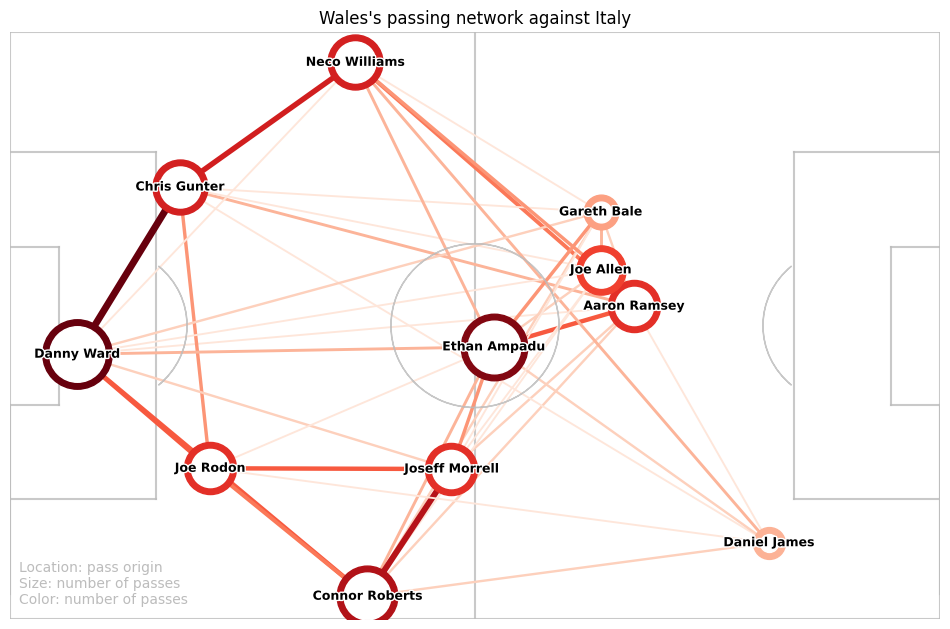

In [245]:
ax = draw_pitch()
ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend, home_team=home_team)

plt.savefig("assets/{0}.png".format(plot_name), facecolor='white', transparent=False)

# Team Sonars

/var/folders/74/wgylnqh57czdw7v6n0vzbw540000gn/T/ipykernel_39959/3435967894.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
/var/folders/74/wgylnqh57czdw7v6n0vzbw540000gn/T/ipykernel_39959/3435967894.py:83: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',


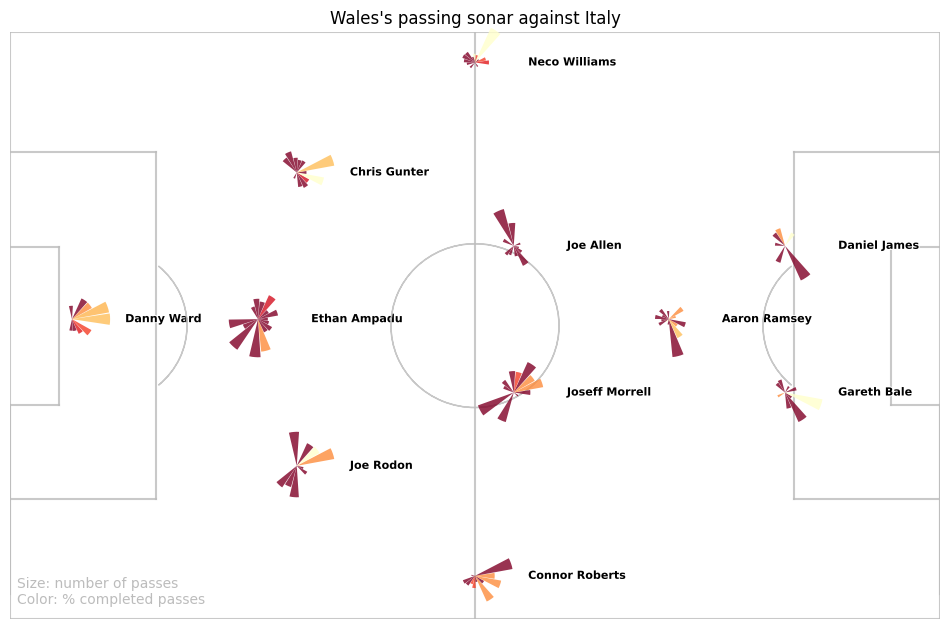

In [265]:
def players_with_coordinates(df, x_list = [8,44,32,32,44,56,66,66,87,87,100], y_list = [45,10,35,55,80,45,25,65,15,75,45], home_team = True):
    team_dict = {}
    if home_team == True:
        for i in df["tactics.lineup"][0]:
            team_dict[i['player']['name']] = []
    else:
        for i in df["tactics.lineup"][1]:
            team_dict[i['player']['name']] = []

    for x,y,z in zip(x_list, y_list, team_dict):
        x,y = _statsbomb_to_point([x,y])
        entry = {z: [x * width, 5 + y * height]}
        team_dict.update(entry)

    return team_dict

def Passer(player, local_df):
    local_df = local_df[local_df["type.name"]=="Pass"]
    local_df = local_df[local_df["player.name"]==player]

    df1 = local_df[['pass.angle','pass.length','pass.outcome.name']].copy()
    bins = np.linspace(-np.pi,np.pi,20)
    df1['binned'] = pd.cut(local_df['pass.angle'], bins, include_lowest=True, right = True)
    df1["Bin_Mids"] = df1["binned"].apply(lambda x: x.mid)
    df1["Complete"] = df1["pass.outcome.name"].apply(lambda x: 1 if pd.isna(x) else 0)
    df1 = df1[:-1]

    A= df1.groupby("Bin_Mids", as_index=False, dropna=False).mean()
    A = A.dropna(axis=0)
    
    return A

def plot_inset(width, axis_main, data, x, y, home_team=True):
    cmap = config["sonar_cmap_home"] if home_team else config["sonar_cmap_away"]

    ax_sub = inset_axes(axis_main, width=width, height=width, loc=10,
                       bbox_to_anchor=(x,y),
                       bbox_transform=axis_main.transData,
                       borderpad=0.0, axes_class=get_projection_class("polar"))

    theta = data["Bin_Mids"]
    radii = data["pass.length"]
    color_metric = data["Complete"]
    bars = ax_sub.bar(theta, radii, width=0.3, bottom=0.0)
    ax_sub.patch.set_alpha(0)
    ax_sub.set_xticklabels([])
    ax_sub.set_yticks([])
    ax_sub.yaxis.grid(False)
    ax_sub.xaxis.grid(False)
    ax_sub.spines['polar'].set_visible(False)

    for r, bar in zip(color_metric, bars):
        bar.set_facecolor(plt.cm.get_cmap(cmap)(r))
        bar.set_alpha(0.8)
    
def draw_pass_sonar(ax, df, team_dict, df_lineup=None, width = .8, use_nicknames=False, home_team=True):
    for player_name, loc in team_dict.items():
        plot_inset(width, ax, data = Passer(player_name, df), x = loc[0], y = loc[1], home_team=home_team)

        if use_nicknames:
            player_name = names_dict[player_name] if names_dict[player_name] else player_name

        ax.text(loc[0]+6, loc[1], player_name, size = 8,ha='left', va='center', weight='bold', 
            path_effects=[pe.Stroke(linewidth=1.5, foreground='white'), pe.Normal()])

    legend = "Size: number of passes\nColor: % completed passes"
    ax.annotate(legend, xy=(1*width, 0.02*height),
                ha="left", va="bottom", zorder=7, fontsize=10, color=config["lines_color"])

    ax.set_title("{0}'s passing sonar against {1}".format(team_name, opponent_team))

x_list_433 = [8,  44,32,32,44,   56,66,66,   87,87,100] 
y_list_433 = [45, 10,35,55,80,   45,25,65,   15,75,45]

x_list_3412 = [8,   37, 32, 37,   60, 60, 65, 65,   100, 100, 85]
y_list_3412 = [45,  65, 45, 25,   80, 10, 55, 35,   55, 35, 45]

df_events = json_to_normalized_dataframe(events_path)
df_lineups = json_to_normalized_dataframe(lineups_path)

team_dict = players_with_coordinates(df_events, x_list=x_list_3412, y_list=y_list_3412, home_team=home_team)

ax = draw_pitch()
draw_pass_sonar(ax, df_events, team_dict, df_lineups, use_nicknames=True, home_team=home_team)

plot_name = "{0}_{1}_passing_sonar".format(match_id, team_name)
plt.savefig("assets/{0}.png".format(plot_name), facecolor='white', transparent=False)
